In [3]:
import pandas as pd
!pip install openpyxl
!pip install seaborn
import seaborn as sns
# Commentez les installations si nécessaire.

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# df = dataset de base
df = pd.read_excel('resultats-par-niveau-subcom-t2-france-entiere.xlsx')


# data2 = dataset quii contient beaucoup d'informations sur les communes (Fiscalité, logement, santé, population,...)
# Il contient donc beaucoup de colonnes et donc pour beaucoup inutiles il faudra procéder à un nettoyage.
# lien: https://www.data.gouv.fr/fr/datasets/data-insee-sur-les-communes/#/resources
data2 = pd.read_excel('MDB-INSEE-V2.xls')


# data3 = dataset qui contient la longitude et la latitude d'une commune.
# lien: https://www.data.gouv.fr/fr/datasets/communes-de-france-base-des-codes-postaux/
data3 = pd.read_csv('communes-departement-region.csv')


# data4 = dataset qui contient la part en % de retraités par commune 
# lien: https://www.observatoire-des-territoires.gouv.fr/part-des-retraites-dans-la-population
data4 = pd.read_csv('data.csv', sep=';')


# PAS UTILITE
# lien: Le même que le dataset de base
# dataTour1 = pd.read_excel('resultats-par-niveau-subcom-t1-france-entiere.xlsx')
# Je ne l'intègre pas dans le dossier car il est très volumineux et que je ne l'utilise pas.
# lien des dataset


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
# Avant de commencer les prédictions je vais changer le nomm des colonnes, qui permettre d'avoir des noms de colonnes plus cohérentes 
df.columns = [
    'code_dep', 'nom_dep', 'code_comm', 'nom_comm', 'etat_saisie', 'nb_inscrits', 'nb_abstentions',
    'tx_abs_ins', 'nb_votants', 'tx_vot_ins', 'nb_blancs', 'tx_blancs_ins','tx_blancs_vot',
     'nb_nuls', 'tx_nuls_ins', 'tx_nuls_vot', 'nb_exprimes', 'tx_exp_ins', 'tx_exp_vot', 
    'num_panneau1', 'sexe_candidat1', 'nom_candidat1', 'prenom_candidat1', 'nb_voix1', 'tx_voix_ins1', 'tx_voix_exp1',
    'num_panneau2', 'sexe_candidat2', 'nom_candidat2', 'prenom_candidat2', 'nb_voix2', 'tx_voix_ins2', 'tx_voix_exp2',
]


# Je vais également rajouter une nouvelle colonne qui concaténera "code_dep" et "code_nom" 
# car ça facilitera la jointure avec les autres dataset.
# Je vais aussi changer les valeurs des codes de département pour certains DOM TOM car c'est incohérent avec les autres dataset
# Exemple 971 représente certains DOM comme Mayotte, Martinique, ... Alors que dans notre dataset de base "df" c'est representé par "ZD" et "ZM"
# Je ne vais pas tous les faire car je vais montrer ensuite que pour le nettoyage j'ai preferé faire une jointure interne (inner join)
# car les autres dataset ne prennent pas en compte toutes les DOM TOM et par exemple, pour les éléctions, nous avons aussi des personnes qui votent depuis l'étranger.
# ce qui est inutile dans nos dataset qui contiennent des données sur des communes françaises.

# Convertir les valeurs de la colonne CodeCommune en chaînes de caractères
df['code_comm'] = df['code_comm'].astype(str)

# Remplacer les valeurs du code de département des DOM TOM par leur vrai code (97)
values_to_replace = ['ZA', 'ZB', 'ZC', 'ZD', 'ZM']
df['code_dep'] = df['code_dep'].replace(values_to_replace, '97')

# Pad avec des zéros à gauche pour que chaque code de département ait une longueur de 2
df['code_dep'] = df['code_dep'].str.pad(width=2, fillchar='0')

# Pad avec des zéros à gauche pour que chaque code de commune ait une longueur de 3
df['code_comm'] = df['code_comm'].str.pad(width=3, fillchar='0')

# Concaténer sans séparateur (ou avec le séparateur désiré)
df['CodeDeptCommune'] = df['code_dep'] + df['code_comm']

# Afficher le DataFrame
print(df[['code_dep', 'code_comm', 'CodeDeptCommune']])




      code_dep code_comm CodeDeptCommune
0           01       001           01001
1           01       002           01002
2           01       004           01004
3           01       005           01005
4           01       006           01006
...        ...       ...             ...
35240       ZZ       229           ZZ229
35241       ZZ       231           ZZ231
35242       ZZ       233           ZZ233
35243       ZZ       234           ZZ234
35244       ZZ       235           ZZ235

[35245 rows x 3 columns]


In [6]:
# FUSION DES DATASET

data_merg1 = pd.merge(df, data2, left_on='CodeDeptCommune', right_on='CODGEO', how='inner')
data_merg1
data_merg1.drop_duplicates(subset='CodeDeptCommune', inplace=True)
data_merg1


code_dep     nom_dep code_comm                 nom_comm etat_saisie  \
0           01         Ain       001  L'Abergement-Clémenciat     Complet   
1           01         Ain       002    L'Abergement-de-Varey     Complet   
2           01         Ain       004        Ambérieu-en-Bugey     Complet   
3           01         Ain       005      Ambérieux-en-Dombes     Complet   
4           01         Ain       006                  Ambléon     Complet   
...        ...         ...       ...                      ...         ...   
34914       97  La Réunion       420           Sainte-Suzanne     Complet   
34915       97  La Réunion       421                  Salazie     Complet   
34916       97  La Réunion       422                Le Tampon     Complet   
34917       97  La Réunion       423        Les Trois-Bassins     Complet   
34918       97  La Réunion       424                   Cilaos     Complet   

       nb_inscrits  nb_abstentions  tx_abs_ins  nb_votants  tx_vot_ins  ...  \
0              643             146       22.71         497       77.29  ...   
1              213              45       21.13         168       78.87  ...   
2             8763            2448       27.94        6315       72.06  ...   
3             1282             266       20.75        1016       79.25  ...   
4              103              19       18.45          84       81.55  ...   
...            ...             ...         ...         ...         ...  ...   
34914        18853            8036       42.62       10817       57.38  ...   
34915         6129            2608       42.55        3521       57.45  ...   
34916        64267           22552       35.09       41715       64.91  ...   
34917         6584            2630       39.95        3954       60.05  ...   
34918         4982            2235       44.86        2747       55.14  ...   

       Score Croissance Entrepreneuriale  Score VA Région  Score PIB  \
0                                0.01585         32.42578   33.83811   
1                                0.00173         32.42578   33.83811   
2                                0.38471         32.42578   33.83811   
3                                0.02824         32.42578   33.83811   
4                                0.00000         32.42578   33.83811   
...                                  ...              ...        ...   
34914                            0.43688          0.13201    0.00000   
34915                            0.13083          0.13201    0.00000   
34916                            2.09129          0.13201    0.00000   
34917                            0.10547          0.13201    0.00000   
34918                            0.08098          0.13201    0.00000   

                          Environnement Démographique        Fidélité  \
0       Bassin Industriel en croissance démographique  Pop Sédentaire   
1      Bassin Résidentiel en croissance démographique  Pop Sédentaire   
2      Bassin Résidentiel en croissance démographique      Pop Mobile   
3           Bassin Urbain en croissance démographique      Pop Mobile   
4      Bassin Résidentiel en croissance démographique  Pop Sédentaire   
...                                               ...             ...   
34914       Bassin Urbain en croissance démographique      Pop Mobile   
34915       Bassin Urbain en croissance démographique      Pop Mobile   
34916       Bassin Urbain en croissance démographique      Pop Mobile   
34917       Bassin Urbain en croissance démographique      Pop Mobile   
34918       Bassin Urbain en croissance démographique      Pop Mobile   

                    SYN MEDICAL    Seg Cap Fiscale         Seg Dyn Entre  \
0             Synergie Médicale  Fiscalité moyenne      Faible dynamique   
1       Forte Synergie Médicale  Fiscalité moyenne      Faible dynamique   
2       Forte Synergie Médicale  Fiscalité moyenne  Dynamique Economique   
3       Forte Synergie Médicale  Fiscalité moyenne     Moyenne dynamique   
4       Fo

In [7]:
# Je prepare les valeurs pour une jointure (ajoutés un 0 avant le sébut d'un code si il n'y a pas 5 chiffres)
data3['code_commune_INSEE'] = data3['code_commune_INSEE'].astype(str).str.zfill(5)
data_merg2 = pd.merge(data_merg1, data3, left_on='CodeDeptCommune', right_on='code_commune_INSEE', how='inner')
# J'ai préféré supprimer les valeurs manquantes plutôt que combler avec une médiane, car les données manquantes ne représentes pas un grand %
# c'est surtout des valeurs de DOM TOM
data_merg2 = data_merg2.dropna(subset=['latitude', 'longitude'])
data_merg2.drop_duplicates(subset='CodeDeptCommune', inplace=True)
data_merg2

code_dep     nom_dep code_comm                 nom_comm etat_saisie  \
0           01         Ain       001  L'Abergement-Clémenciat     Complet   
1           01         Ain       002    L'Abergement-de-Varey     Complet   
2           01         Ain       004        Ambérieu-en-Bugey     Complet   
3           01         Ain       005      Ambérieux-en-Dombes     Complet   
4           01         Ain       006                  Ambléon     Complet   
...        ...         ...       ...                      ...         ...   
37837       97  La Réunion       420           Sainte-Suzanne     Complet   
37838       97  La Réunion       421                  Salazie     Complet   
37840       97  La Réunion       422                Le Tampon     Complet   
37846       97  La Réunion       423        Les Trois-Bassins     Complet   
37847       97  La Réunion       424                   Cilaos     Complet   

       nb_inscrits  nb_abstentions  tx_abs_ins  nb_votants  tx_vot_ins  ...  \
0              643             146       22.71         497       77.29  ...   
1              213              45       21.13         168       78.87  ...   
2             8763            2448       27.94        6315       72.06  ...   
3             1282             266       20.75        1016       79.25  ...   
4              103              19       18.45          84       81.55  ...   
...            ...             ...         ...         ...         ...  ...   
37837        18853            8036       42.62       10817       57.38  ...   
37838         6129            2608       42.55        3521       57.45  ...   
37840        64267           22552       35.09       41715       64.91  ...   
37846         6584            2630       39.95        3954       60.05  ...   
37847         4982            2235       44.86        2747       55.14  ...   

        latitude  longitude  code_commune  article            nom_commune  \
0      46.153426   4.926114           1.0       L'  Abergement-Clémenciat   
1      46.009188   5.428017           2.0       L'    Abergement-de-Varey   
2      45.960848   5.372926           4.0      NaN      Ambérieu-en-Bugey   
3      45.996180   4.912273           5.0      NaN    Ambérieux-en-Dombes   
4      45.749499   5.594320           6.0      NaN                Ambléon   
...          ...        ...           ...      ...                    ...   
37837 -20.945734  55.592779          20.0      NaN         Sainte-Suzanne   
37838 -21.046919  55.508238          21.0      NaN                Salazie   
37840 -21.223275  55.558488          22.0       Le                 Tampon   
37846 -21.110475  55.329752          23.0      Les          Trois-Bassins   
37847 -21.144166  55.458604          24.0      NaN                 Cilaos   

           nom_commune_complet  code_departement  nom_departement  \
0      L'Abergement-Clémenciat                 1              Ain   
1        L'Abergement-de-Varey                 1              Ain   
2            Ambérieu-en-Bugey                 1              Ain   
3          Ambérieux-en-Dombes                 1              Ain   
4                      Ambléon                 1              Ain   
...                        ...               ...              ...   
37837           Sainte-Suzanne               974       La Réunion   
37838                  Salazie               974       La Réunion   
37840                Le Tampon               974       La Réunion   
37846        Les Trois-Bassins               974       La Réunion   
37847                   Cilaos               974       La Réunion   

       code_region            nom_region  
0             84.0  Auvergne-Rhône-Alpes  
1             84.0  Auvergne-Rhône-Alpes  
2             84.0  Auvergne-Rhône-Alpes  
3             84.0  Auvergne-Rhône-Alpes  
4             84.0  Auvergne-Rhône-Alpes  
...            ...                   ...  
37837          4.0            La Réunion  
37838          4.0            La R

In [8]:
# Le dataset contient des valeurs considérér comme "NAN".'N/A - résultat non disponible' par NaN.
# Méthode query pour filtrer le DataFrame
data4 = data4.query('`Part des "retraités" dans la population 2020` != "N/A - résultat non disponible"')
data4 = data4.query('`Part des "retraités" dans la population 2020` != "N/A - division par 0"')

data4['Code'] = data4['Code'].astype(str).str.zfill(5)
data4

# Denière Fusion pour ajouter les taux de retraités.
data_merg3 = pd.merge(data_merg2, data4, left_on='CodeDeptCommune', right_on='Code', how='inner')
data_merg3

code_dep     nom_dep code_comm                 nom_comm etat_saisie  \
0           01         Ain       001  L'Abergement-Clémenciat     Complet   
1           01         Ain       002    L'Abergement-de-Varey     Complet   
2           01         Ain       004        Ambérieu-en-Bugey     Complet   
3           01         Ain       005      Ambérieux-en-Dombes     Complet   
4           01         Ain       006                  Ambléon     Complet   
...        ...         ...       ...                      ...         ...   
34890       97  La Réunion       420           Sainte-Suzanne     Complet   
34891       97  La Réunion       421                  Salazie     Complet   
34892       97  La Réunion       422                Le Tampon     Complet   
34893       97  La Réunion       423        Les Trois-Bassins     Complet   
34894       97  La Réunion       424                   Cilaos     Complet   

       nb_inscrits  nb_abstentions  tx_abs_ins  nb_votants  tx_vot_ins  ...  \
0              643             146       22.71         497       77.29  ...   
1              213              45       21.13         168       78.87  ...   
2             8763            2448       27.94        6315       72.06  ...   
3             1282             266       20.75        1016       79.25  ...   
4              103              19       18.45          84       81.55  ...   
...            ...             ...         ...         ...         ...  ...   
34890        18853            8036       42.62       10817       57.38  ...   
34891         6129            2608       42.55        3521       57.45  ...   
34892        64267           22552       35.09       41715       64.91  ...   
34893         6584            2630       39.95        3954       60.05  ...   
34894         4982            2235       44.86        2747       55.14  ...   

       article            nom_commune      nom_commune_complet  \
0           L'  Abergement-Clémenciat  L'Abergement-Clémenciat   
1           L'    Abergement-de-Varey    L'Abergement-de-Varey   
2          NaN      Ambérieu-en-Bugey        Ambérieu-en-Bugey   
3          NaN    Ambérieux-en-Dombes      Ambérieux-en-Dombes   
4          NaN                Ambléon                  Ambléon   
...        ...                    ...                      ...   
34890      NaN         Sainte-Suzanne           Sainte-Suzanne   
34891      NaN                Salazie                  Salazie   
34892       Le                 Tampon                Le Tampon   
34893      Les          Trois-Bassins        Les Trois-Bassins   
34894      NaN                 Cilaos                   Cilaos   

       code_departement  nom_departement  code_region            nom_region  \
0                     1              Ain         84.0  Auvergne-Rhône-Alpes   
1                     1              Ain         84.0  Auvergne-Rhône-Alpes   
2                     1              Ain         84.0  Auvergne-Rhône-Alpes   
3                     1              Ain         84.0  Auvergne-Rhône-Alpes   
4                     1              Ain         84.0  Auvergne-Rhône-Alpes   
...                 ...              ...          ...                   ...   
34890               974       La Réunion          4.0            La Réunion   
34891               974       La Réunion          4.0            La Réunion   
34892               974       La Réunion          4.0            La Réunion   
34893               974       La Réunion          4.0            La Réunion   
34894               974       La Réunion          4.0            La Réunion   

        Code                  Libellé  \
0      01001  L'Abergement-Clémenciat   
1      01002    L'Abergement-de-Varey   
2      01004        Ambérieu-en-Bugey   
3      01005      Ambérieux-en-Dombes   
4      01006                  Ambléon   
...      ...                      ...   
34890  97420           Sainte-Suzanne   
34891  97421                  Salazie   
34892  97422         

In [9]:
# Dernier dataset qui permet de prédire en fonction des résultat du premier tour des 2 candidats
# On fait le même traitement que le 1er dataset car ils sont semblables (lun provient du 1er tour et lautre du 2nd)

# dataTour1.rename(columns={'Code du département': 'code_dep'}, inplace=True)
# dataTour1.rename(columns={'Code de la commune': 'code_comm'}, inplace=True)


# dataTour1['code_comm'] = dataTour1['code_comm'].astype(str)

# # Remplacer les valeurs du code de département des DOM TOM par leur vrai code (97)
# values_to_replace = ['ZA', 'ZB', 'ZC', 'ZD', 'ZM']
# dataTour1['code_dep'] = dataTour1['code_dep'].replace(values_to_replace, '97')

# # Pad avec des zéros à gauche pour que chaque code de département ait une longueur de 2
# dataTour1['code_dep'] = dataTour1['code_dep'].str.pad(width=2, fillchar='0')

# # Pad avec des zéros à gauche pour que chaque code de commune ait une longueur de 3
# dataTour1['code_comm'] = dataTour1['code_comm'].str.pad(width=3, fillchar='0')

# # Concaténer sans séparateur (ou avec le séparateur désiré)
# dataTour1['CodeDeptCommune2'] = dataTour1['code_dep'] + dataTour1['code_comm']

# # Afficher le DataFrame
# print(dataTour1[['code_dep', 'code_comm', 'CodeDeptCommune']])

# data_merg4 = pd.merge(data_merg3, dataTour1, left_on='CodeDeptCommune', right_on='CodeDeptCommune2', how='inner')
# data_merg4

In [10]:
# liste_colonnes = pre_final.columns.tolist()
# liste_colonnes

In [12]:
# On garde les colonnes qui nous interesse et on enlève ceux que nous allons pas utiliser et qui ont été ajoutés à cause des jointures.

columns = [
     'nom_dep', 'nom_comm', 'nb_inscrits', 'nb_abstentions',
    'tx_abs_ins', 'nb_votants', 'tx_vot_ins', 'nb_blancs', 'tx_blancs_ins','tx_blancs_vot',
     'nb_nuls', 'tx_nuls_ins', 'tx_nuls_vot', 'nb_exprimes', 'tx_exp_ins', 'tx_exp_vot', 
    'nom_candidat1', 'nb_voix1', 'tx_voix_ins1', 'tx_voix_exp1',
    'nom_candidat2', 'nb_voix2', 'tx_voix_ins2', 'tx_voix_exp2',
    'Part des "retraités" dans la population 2020', 'latitude', 'longitude', 'Moyenne Revenus Fiscaux Départementaux',
    
]
final_df = data_merg3[columns].copy()
final_df

nom_dep                 nom_comm  nb_inscrits  nb_abstentions  \
0             Ain  L'Abergement-Clémenciat          643             146   
1             Ain    L'Abergement-de-Varey          213              45   
2             Ain        Ambérieu-en-Bugey         8763            2448   
3             Ain      Ambérieux-en-Dombes         1282             266   
4             Ain                  Ambléon          103              19   
...           ...                      ...          ...             ...   
34890  La Réunion           Sainte-Suzanne        18853            8036   
34891  La Réunion                  Salazie         6129            2608   
34892  La Réunion                Le Tampon        64267           22552   
34893  La Réunion        Les Trois-Bassins         6584            2630   
34894  La Réunion                   Cilaos         4982            2235   

       tx_abs_ins  nb_votants  tx_vot_ins  nb_blancs  tx_blancs_ins  \
0           22.71         497       77.29         42           6.53   
1           21.13         168       78.87         23          10.80   
2           27.94        6315       72.06        461           5.26   
3           20.75        1016       79.25         47           3.67   
4           18.45          84       81.55         12          11.65   
...           ...         ...         ...        ...            ...   
34890       42.62       10817       57.38        436           2.31   
34891       42.55        3521       57.45        100           1.63   
34892       35.09       41715       64.91       2208           3.44   
34893       39.95        3954       60.05        203           3.08   
34894       44.86        2747       55.14         85           1.71   

       tx_blancs_vot  ...  tx_voix_ins1  tx_voix_exp1  nom_candidat2  \
0               8.45  ...         36.86         52.67         LE PEN   
1              13.69  ...         44.13         66.20         LE PEN   
2               7.30  ...         35.15         54.14         LE PEN   
3               4.63  ...         35.18         47.27         LE PEN   
4              14.29  ...         43.69         62.50         LE PEN   
...              ...  ...           ...           ...            ...   
34890           4.03  ...         18.48         35.07         LE PEN   
34891           2.84  ...         18.32         34.20         LE PEN   
34892           5.29  ...         19.18         32.57         LE PEN   
34893           5.13  ...         20.52         38.26         LE PEN   
34894           3.09  ...         15.44         30.22         LE PEN   

       nb_voix2  tx_voix_ins2  tx_voix_exp2  \
0           213         33.13         47.33   
1            48         22.54         33.80   
2          2609         29.77         45.86   
3           503         39.24         52.73   
4            27         26.21         37.50   
...         ...           ...           ...   
34890      6450         34.21         64.93   
34891      2161         35.26         65.80   
34892     25522         39.71         67.43   
34893      2180         33.11         61.74   
34894      1776         35.65         69.78   

      Part des "retraités" dans la population 2020   latitude  longitude  \
0                                               28  46.153426   4.926114   
1                                             33.2  46.009188   5.428017   
2                                               25  45.960848   5.372926   
3                                             24.4  45.996180   4.912273   
4                                             21.3  45.749499   5.594320   
...                                            ...        ...        ...   
34890                                         12.9 -20.945734  55.592779   
34891                                         12.4 -21.046919  55.508238   
34892                                         17.1 -21.223275  55.558488   
34893                                         12.1 -21.110475  55.

In [13]:
# MATRICE DE CORRELATION
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que final_df est votre DataFrame complet

# Choisissez les colonnes pour lesquelles vous voulez calculer la matrice de corrélation
selected_columns = ['nb_inscrits', 'nb_votants', 'Part des "retraités" dans la population 2020', 
                    'latitude', 'longitude', 'Moyenne Revenus Fiscaux Départementaux',
                   'tx_voix_exp1','tx_voix_exp2',]
selected_df = final_df[selected_columns]

# Calcul de la matrice de corrélation pour les colonnes sélectionnées
corr_matrix = selected_df.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)

# Ajouter un titre et des ajustements pour la lisibilité
plt.title('Matrice de corrélation pour les colonnes sélectionnées')
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0) 

# Afficher la heatmap
plt.show()



In [14]:
# On voit qu'il n'y a pas de grandes corrélation entre les features à part la diagonale et les taux de vote des candidats.

In [15]:
# TRAITEMENT ET APPRENTISSAGE
#Regression logistique
# J'ai voulu commencé par une regréssion logistique qui aura pour valeur cible Y, une colonne que j'ai ajouté qui contiendra 1 ou 0:
# 1 pour une commune remporté par Macron, 0 pour Lepen -> Classification Binaire.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Charger les données

# Renommer les colonnes pour faciliter l'accès
# Remplacer par les noms de colonnes appropriés si nécessaire

# Transformer les pourcentages de voix en une variable binaire : 1 si > 50%, sinon 0
final_df['Y'] = (final_df['tx_voix_exp1'] > final_df['tx_voix_exp2']).astype(int)
features = ['nb_inscrits', 'nb_votants', 'Part des "retraités" dans la population 2020', 'latitude', 'longitude', 'Moyenne Revenus Fiscaux Départementaux']
# features = ['nb_inscrits', 'tx_abs_ins', 'tx_vot_ins', 'tx_blancs_ins', 'tx_nuls_ins', 'nb_exprimes', 'latitude', 'longitude',]

X = final_df[features]
y_candidat = final_df['Y']
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train_candidat, y_test_candidat = train_test_split(X, y_candidat, test_size=0.2, random_state=42)

# Normalisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement du modèle de régression logistique pour le candidat 1
model_candidat = LogisticRegression()
model_candidat.fit(X_train_scaled, y_train_candidat)

# Prédiction sur l'ensemble de test pour les deux candidats
y_pred_candidat = model_candidat.predict(X_test_scaled)

# Évaluation de la précision
accuracy_candidat = accuracy_score(y_test_candidat, y_pred_candidat)

print('Précision pour le candidat:', accuracy_candidat)

# Rapport de classification
print('\nRapport de classification pour le candidat:')
print(classification_report(y_test_candidat, y_pred_candidat))

Précision pour le candidat: 0.6394898982662273

Rapport de classification pour le candidat:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3744
           1       0.66      0.46      0.54      3235

    accuracy                           0.64      6979
   macro avg       0.64      0.63      0.62      6979
weighted avg       0.64      0.64      0.63      6979



In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions (assurez-vous que votre modèle est entraîné et que vous avez fait les prédictions)
y_pred_candidat = model_candidat.predict(X_test_scaled)

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_candidat, y_pred_candidat)

# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Il réussi bien à prédire La classe 0 (LEPEN) , la raison est peut-être du au fait qu'il y a plus de 0 (Lepen) que de 1 pour chaque commune.
# LEPEN a gagné plus de commune que MACRON malgré le fait qu'elle est perdu et comme on s'occupe de prédire par territoire, il est possible que mon modèle prédit plus LEPEN que MACRON.

In [18]:
from sklearn.linear_model import LogisticRegressionCV

# Préparation des données déjà effectuée

# Entraînement du modèle de régression logistique avec régularisation L1
model_candidat_L1 = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=50, cv=5, random_state=42)
model_candidat_L1.fit(X_train_scaled, y_train_candidat)

# Prédiction sur l'ensemble de test pour le modèle L1
y_pred_candidat_L1 = model_candidat_L1.predict(X_test_scaled)

# Évaluation de la précision pour le modèle L1
accuracy_candidat_L1 = accuracy_score(y_test_candidat, y_pred_candidat_L1)

print('Précision pour le modèle L1 (Lasso) :', accuracy_candidat_L1)

# Rapport de classification pour le modèle L1
print('\nRapport de classification pour le modèle L1 (Lasso):')
print(classification_report(y_test_candidat, y_pred_candidat_L1))


Précision pour le modèle L1 (Lasso) : 0.6379137412236711

Rapport de classification pour le modèle L1 (Lasso):
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3744
           1       0.65      0.47      0.54      3235

    accuracy                           0.64      6979
   macro avg       0.64      0.63      0.62      6979
weighted avg       0.64      0.64      0.63      6979



In [19]:
# LR2 avec StandardScaler

# Entraînement du modèle de régression logistique avec régularisation L2
model_candidat_L2 = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, random_state=42)
model_candidat_L2.fit(X_train_scaled, y_train_candidat)

# Prédiction sur l'ensemble de test pour le modèle L2
y_pred_candidat_L2 = model_candidat_L2.predict(X_test_scaled)

# Évaluation de la précision pour le modèle L2
accuracy_candidat_L2 = accuracy_score(y_test_candidat, y_pred_candidat_L2)

print('Précision pour le modèle L2 (Ridge) :', accuracy_candidat_L2)

# Rapport de classification pour le modèle L2
print('\nRapport de classification pour le modèle L2 (Ridge):')
print(classification_report(y_test_candidat, y_pred_candidat_L2))



Précision pour le modèle L2 (Ridge) : 0.6379137412236711

Rapport de classification pour le modèle L2 (Ridge):
              precision    recall  f1-score   support

           0       0.63      0.79      0.70      3744
           1       0.65      0.47      0.54      3235

    accuracy                           0.64      6979
   macro avg       0.64      0.63      0.62      6979
weighted avg       0.64      0.64      0.63      6979



In [20]:
# À partir de ce dataset seul, notre accuracy est de  ~63%
# Quelque soit la régularisation. Cela peut-être du au fait que le modèle de base n'a pas de problème de surajustement.

In [21]:
# Compter le pourcentage de 0 et de 1 dans la colonne 'Y'
percentage_counts = final_df['Y'].value_counts(normalize=True)

# Afficher les résultats en pourcentage
print(percentage_counts)
# Permet de savoir que LEPEN a gagné plus de communes que MACRON

Y
0    0.530248
1    0.469752
Name: proportion, dtype: float64


In [22]:
# ARBRE
# J'ai choisi cette fois-ci un arbre de décision car c'est facile à comprendre et à interpréter
#  Et également Il peut gérer des relations non linéaires

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Définition des valeurs de profondeur maximale et de min_samples_split à tester
max_depth_values = [10, 15, 20]
min_samples_split_values = [2, 5, 10]

mean_scores = []

# Boucle sur les valeurs de profondeur maximale
for max_depth in max_depth_values:
    # Boucle sur les valeurs de min_samples_split
    for min_samples_split in min_samples_split_values:
        # Création du modèle d'arbre de décision avec les paramètres spécifiés
        tree_classifier = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        
        # Validation croisée avec 5 plis
        scores = cross_val_score(tree_classifier, X_train_scaled, y_train_candidat, cv=5)
        
        # Calcul de la moyenne des scores
        mean_score = np.mean(scores)
        
        # Ajout du score moyen à la liste
        mean_scores.append((max_depth, min_samples_split, mean_score))

# Affichage des résultats
for max_depth, min_samples_split, mean_score in mean_scores:
    print(f"Profondeur maximale : {max_depth}, Min samples split : {min_samples_split}, Score moyen : {mean_score}")



Profondeur maximale : 10, Min samples split : 2, Score moyen : 0.7055454493199012
Profondeur maximale : 10, Min samples split : 5, Score moyen : 0.7052947073263238
Profondeur maximale : 10, Min samples split : 10, Score moyen : 0.7051155921552688
Profondeur maximale : 15, Min samples split : 2, Score moyen : 0.7156830023295238
Profondeur maximale : 15, Min samples split : 5, Score moyen : 0.7150383224350221
Profondeur maximale : 15, Min samples split : 10, Score moyen : 0.7162920003264105
Profondeur maximale : 20, Min samples split : 2, Score moyen : 0.7050797755363576
Profondeur maximale : 20, Min samples split : 5, Score moyen : 0.7060469333070564
Profondeur maximale : 20, Min samples split : 10, Score moyen : 0.7074439867341864


Accuracy sur l'ensemble de test: 0.7134259922625018


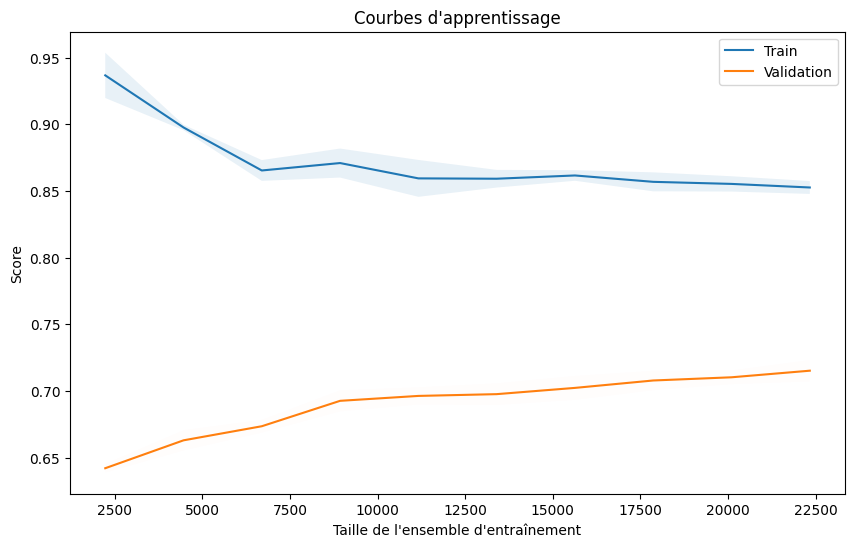

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Définition des valeurs de profondeur maximale et de min_samples_split
max_depth = 15
min_samples_split = 5

# Création du modèle d'arbre de décision avec les paramètres spécifiés
tree_classifier = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)

X_train, X_test, y_train, y_test = train_test_split(X, y_candidat, test_size=0.2, random_state=42)

# Entraînement du modèle sur l'ensemble d'entraînement
tree_classifier.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_test = tree_classifier.predict(X_test)

# Calcul de l'accuracy sur l'ensemble de test
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy sur l'ensemble de test:", accuracy_test)

# Courbes d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(tree_classifier, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# Calcul des moyennes et des écarts-types des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, val_scores_mean, label='Validation')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.01)
plt.xlabel('Taille de l\'ensemble d\'entraînement')
plt.ylabel('Score')
plt.title('Courbes d\'apprentissage')
plt.legend()
plt.show()


In [25]:
# Les bons paramètres ont été choisis grâce à la validation croisée.
# Et la courbe indique qu'il n'y a pas de surajustement.

In [26]:
# Forêt Aléatoire
# En dernier je choisi les forêt aléatoires car elle performe sans faire beaucoup d'ajustement 
# Et peut traiter à la fois des données binaire et continues sans avoir besoin de normalisation

Accuracy sur l'ensemble de test: 0.732639220555927


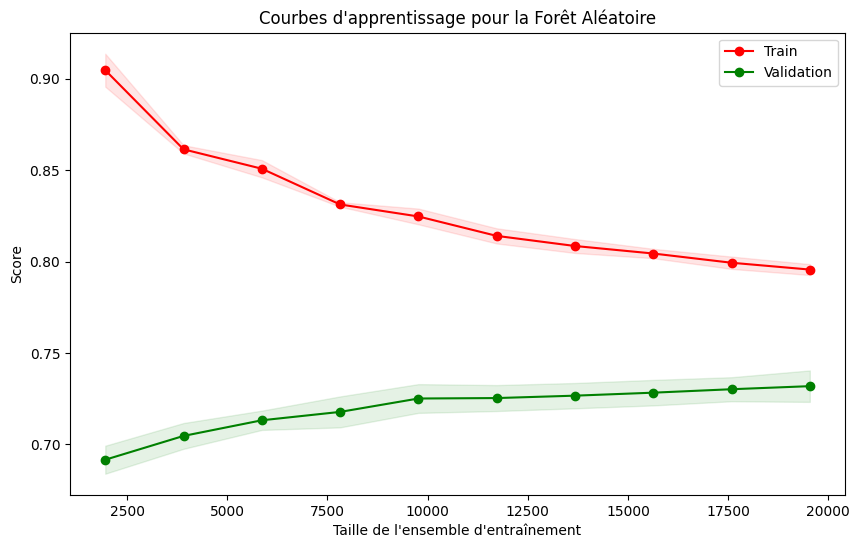

In [27]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Paramètres pour la forêt aléatoire
n_estimators = 100  # Nombre d'arbres dans la forêt
max_depth = 10    # Profondeur maximale des arbres
min_samples_split = 5  # Nombre minimum d'échantillons requis pour diviser un nœud

# Création du modèle de forêt aléatoire avec les paramètres spécifiés
rf_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       random_state=42)

# Séparation des données en ensembles d'entraînement et de test
# Notez que X et y_candidat1 doivent être définis quelque part dans votre code avant cette étape
X_train, X_test, y_train, y_test = train_test_split(X, y_candidat, test_size=0.3, random_state=42)

# Entraînement du modèle sur l'ensemble d'entraînement
rf_classifier.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_test = rf_classifier.predict(X_test)

# Calcul de l'accuracy sur l'ensemble de test
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sur l'ensemble de test: {accuracy_test}")

# Courbes d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(rf_classifier, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# Calcul des moyennes et des écarts-types des scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label='Train')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label='Validation')
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="g", alpha=0.1)
plt.xlabel('Taille de l\'ensemble d\'entraînement')
plt.ylabel('Score')
plt.title('Courbes d\'apprentissage pour la Forêt Aléatoire')
plt.legend()
plt.show()


In [28]:
# Ce modèle a une bonne accuracy de plus, au vu du graphe il n'y a pas de sur ajustement visible car la courbe n'est pas beaucoup plus élevé que celle de la validation.

In [29]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calcul de l'accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy}")

# Calcul du score F1
f1 = f1_score(y_test, y_pred_test)
print(f"F1 Score: {f1}")

# Calcul de la précision
precision = precision_score(y_test, y_pred_test)
print(f"Precision: {precision}")

# Calcul du rappel
recall = recall_score(y_test, y_pred_test)
print(f"Recall: {recall}")
print(classification_report(y_test, y_pred_test))


Accuracy: 0.732639220555927
F1 Score: 0.7004815409309791
Precision: 0.725720620842572
Recall: 0.6769389865563599
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      5634
           1       0.73      0.68      0.70      4835

    accuracy                           0.73     10469
   macro avg       0.73      0.73      0.73     10469
weighted avg       0.73      0.73      0.73     10469



In [30]:
# Je n'ai pas réussi à implémenter le feature des résultat du 1er tour pour les 2 candidats, qui aurait été à mon avis une bonne feature. 

In [ ]:
# La plus grosse partie que ce soit en terme de difficulté ou en terme de temps perdu a été pour moi la fusion des datasets.
# J'aurais du me focus sur quelques features seulement et priviligié l'apprentissage plutôt que le traitement de donnée

In [ ]:
# REGRESSION

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Supposons que `election_data` est votre DataFrame
target = 'tx_voix_exp1'  # Votre variable cible

X = final_df[features]
y = final_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Prédiction et évaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R^2: {r2}")


In [ ]:
#MODELE DE REGRESSION PAS BONNE